# Sound Event Detection with Depthwise Separable and Dilated Convolutions

## Import libraries

In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator

print("Tensorflow version %s" %tf.__version__)
print("Keras version %s" %keras.__version__)

Tensorflow version 2.4.1
Keras version 2.4.3


## Load data and get mel spectrogram from audio

In [2]:
# Load various imports 
import pandas as pd
import os
import librosa

max_pad_len = 174

def extract_features(file_name):
   
    #try:
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        #melspec_args = {"n_fft": 160, "hop_length": 80, "window":  get_window("hamming", 0.02)}
        #mfccs = librosa.feature.mfcc(y=y, sr=sr, S=None, n_mfcc=12, **melspec_args)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=1024, n_mels=40)
    pad_width = max_pad_len - mfccs.shape[1]
    mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    #except Exception as e:
    #    print("Error encountered while parsing file: ", file_name)
    #    return None 
     
    return mfccs
    
# Set the path to the full UrbanSound dataset 
fulldatasetpath = '/Xception/UrbanSound8K/audio/'

metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')

features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"]),str(row["slice_file_name"]))
    
    class_label = row["class"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')

E:\anaconda3\envs\hello-tf\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
E:\anaconda3\envs\hello-tf\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
E:\anaconda3\envs\hello-tf\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(


Finished feature extraction from  8732  files


## Preprocess data

In [3]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [4]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_rows = 40
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 173, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 86, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 41, 64)         8

## Model

In [6]:
from keras.models import Sequential
from keras.layers import SeparableConv2D, ZeroPadding2D, Activation, Dropout, Dense, \
                            Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras import Input, optimizers

num_rows = 40
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]

def Net(input_shape, num_classes, dilated_kernel, dilation, dilated_padding):

    model = Sequential()
    
    # input layer
    #model.add(Input(shape=(256,256,1)))#TODO ADD REAL SIZE
    model.add(Input(shape=(num_rows, num_columns, num_channels)))
    
    # DWS-CNN layer 1
    model.add(ZeroPadding2D(padding=(2)))
    # use valid padding since padding is introduced before since it has a special form
    model.add(SeparableConv2D(256,kernel_size=(5,5), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())
    # Pooling
    model.add(MaxPooling2D(pool_size=(1,5), strides=(1,5), padding='valid'))
    # Dropout
    model.add(Dropout(0.25))
    
    # DWS-CNN layer 2
    model.add(ZeroPadding2D(padding=(2, 2)))
    # use valid padding since padding is introduced before since it has a special form
    model.add(SeparableConv2D(256,kernel_size=(5,5), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())
    # Pooling
    model.add(MaxPooling2D(pool_size=(1,4), strides=(1,4), padding='valid'))
    # Dropout
    model.add(Dropout(0.25))
    
    # DWS-CNN layer 3
    model.add(ZeroPadding2D(padding=(2, 2)))
    # use valid padding since padding is introduced before since it has a special form
    model.add(SeparableConv2D(256,kernel_size=(5,5), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())
    # Pooling
    model.add(MaxPooling2D(pool_size=(1,2), strides=(1,2), padding='valid'))
    # Dropout
    model.add(Dropout(0.25))
    
    # DIL-CNN 
    model.add(ZeroPadding2D(padding=(0, dilated_padding*dilation)))
    model.add(Conv2D(256, kernel_size=dilated_kernel, dilation_rate=(1,dilation)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    # classifier layer
    #model.add(Flatten())
    model.add(GlobalAveragePooling2D(name='avg_pool'))
    model.add(Dense(num_labels))
    model.add(Activation('sigmoid'))
    
    # model compilation for training
    adam = optimizers.Adam(lr=0.0001)
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=metrics)
    
    return model


# create the model
input_shape = (16, 16, 16, 1)
num_classes = 16
dilated_kernel = (3,3)
dilation = (10)
dilated_padding = 2
model = Net(input_shape,num_classes,dilated_kernel,dilation,dilated_padding)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_4 (ZeroPaddin (None, 44, 178, 1)        0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 40, 174, 256)      537       
_________________________________________________________________
activation_5 (Activation)    (None, 40, 174, 256)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 40, 174, 256)      1024      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 40, 34, 256)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 34, 256)       0         
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 44, 38, 256)      

## Train the model

In [7]:
#from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 50
num_batch_size = 16

#checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
#                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/50
437/437 [==============================] - 330s 754ms/step - loss: 1.8484 - accuracy: 0.3285 - precision_1: 0.1701 - recall_1: 0.9064 - val_loss: 2.5427 - val_accuracy: 0.1214 - val_precision_1: 0.1324 - val_recall_1: 0.5518
Epoch 2/50
437/437 [==============================] - 324s 742ms/step - loss: 1.2875 - accuracy: 0.5386 - precision_1: 0.2078 - recall_1: 0.9651 - val_loss: 1.6068 - val_accuracy: 0.4276 - val_precision_1: 0.2048 - val_recall_1: 0.9153
Epoch 3/50
437/437 [==============================] - 326s 746ms/step - loss: 1.1065 - accuracy: 0.6261 - precision_1: 0.2179 - recall_1: 0.9736 - val_loss: 1.7470 - val_accuracy: 0.4408 - val_precision_1: 0.2182 - val_recall_1: 0.9153
Epoch 4/50
437/437 [==============================] - 330s 755ms/step - loss: 1.0106 - accuracy: 0.6650 - precision_1: 0.2268 - recall_1: 0.9713 - val_loss: 1.3928 - val_accuracy: 0.5140 - val_precision_1: 0.2303 - val_recall_1: 0.9359
Epoch 5/50
437/437 [==============================] - 33

Epoch 36/50
437/437 [==============================] - 352s 807ms/step - loss: 0.2947 - accuracy: 0.9046 - precision_1: 0.4398 - recall_1: 0.9831 - val_loss: 0.5413 - val_accuracy: 0.8369 - val_precision_1: 0.3788 - val_recall_1: 0.9674
Epoch 37/50
437/437 [==============================] - 350s 802ms/step - loss: 0.3017 - accuracy: 0.9053 - precision_1: 0.4484 - recall_1: 0.9803 - val_loss: 0.4329 - val_accuracy: 0.8632 - val_precision_1: 0.3910 - val_recall_1: 0.9697
Epoch 38/50
437/437 [==============================] - 327s 749ms/step - loss: 0.2826 - accuracy: 0.9186 - precision_1: 0.4564 - recall_1: 0.9813 - val_loss: 0.5461 - val_accuracy: 0.8317 - val_precision_1: 0.3772 - val_recall_1: 0.9634
Epoch 39/50
437/437 [==============================] - 325s 743ms/step - loss: 0.2912 - accuracy: 0.9092 - precision_1: 0.4587 - recall_1: 0.9838 - val_loss: 0.6746 - val_accuracy: 0.8231 - val_precision_1: 0.3585 - val_recall_1: 0.9496
Epoch 40/50
437/437 [==============================]

## Evaluate the model

In [11]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=num_batch_size)
print("test loss: ", results[0], "test acc: ", results[1])
print("test precision: ", results[2], "test recall: ", results[3])
print("test F1 score ", 2*results[2]*results[3]/(results[2]+results[3]))

Evaluate on test data
110/110 [==============================] - 18s 166ms/step - loss: 0.3518 - accuracy: 0.8895 - precision_1: 0.4256 - recall_1: 0.9765
test loss:  0.3518184423446655 test acc:  0.8895248770713806
test precision:  0.42564868927001953 test recall:  0.9765312075614929
test F1 score  0.5928757493515326


In [24]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps=437

preds = model.predict(x_test,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = y_test

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))

437/437 [==============================] - 20s 46ms/step


NameError: name 'classnames' is not defined

## Plot results

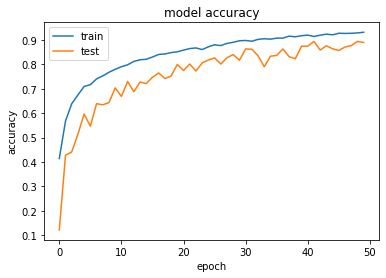

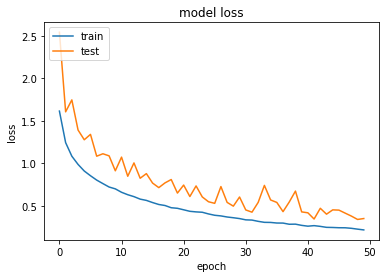

In [9]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()